<a href="https://colab.research.google.com/github/Nirzu97/pyprobml/blob/matrix-factorization/notebooks/matrix_factorization_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization for Movie Lens Recommendations 

This notebook is based on  code from Nick Becker 

https://github.com/beckernick/matrix_factorization_recommenders/blob/master/matrix_factorization_recommender.ipynb







# Setting Up the Ratings Data

We read the data directly from MovieLens website, since they don't allow redistribution. We want to include the metadata (movie titles, etc), not just the ratings matrix.


In [23]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt


In [24]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!ls
!unzip ml-100k
folder = 'ml-100k'

--2021-04-20 14:51:30--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  5.71MB/s    in 0.8s    

2021-04-20 14:51:31 (5.71 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

ml-100k  ml-100k.zip  ml-100k.zip.1  ml-1m  ml-1m.zip  sample_data
Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.use

In [25]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m
!ls
folder = 'ml-1m'


--2021-04-20 14:52:53--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  6.81MB/s    in 0.8s    

2021-04-20 14:52:54 (6.81 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
ml-100k  ml-100k.zip  ml-100k.zip.1  ml-1m  ml-1m.zip  ml-1m.zip.1  sample_data


In [26]:

ratings_list = [ [int(x) for x in i.strip().split("::")] for i in open(os.path.join(folder,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(folder, 'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(folder, 'movies.dat'), 'r',  encoding="latin-1").readlines()]



In [27]:
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [28]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
def get_movie_name(movies_df, movie_id_str):
  ndx = (movies_df['MovieID']==int(movie_id_str))
  name = movies_df['Title'][ndx].to_numpy()[0]
  return name

print(get_movie_name(movies_df, 1))
print(get_movie_name(movies_df, "527"))

Toy Story (1995)
Schindler's List (1993)


In [30]:
def get_movie_genres(movies_df, movie_id_str):
  ndx = (movies_df['MovieID']==int(movie_id_str))
  name = movies_df['Genres'][ndx].to_numpy()[0]
  return name

print(get_movie_genres(movies_df, 1))
print(get_movie_genres(movies_df, "527"))

Animation|Children's|Comedy
Drama|War


In [31]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


These look good, but I want the format of my ratings matrix to be one row per user and one column per movie. I'll `pivot` `ratings_df` to get that and call the new variable `R`.

In [32]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The last thing I need to do is de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [33]:
R = R_df.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

print(R.shape)
print(np.count_nonzero(R))

(6040, 3706)
1000209


# Singular Value Decomposition

Scipy and Numpy both have functions to do the singular value decomposition. I'm going to use the Scipy function `svds` because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [34]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
sigma = np.diag(sigma)

In [35]:
latents = [10, 20, 50]
errors = []
for latent_dim in latents:
  U, sigma, Vt = svds(R_demeaned, k = latent_dim)
  sigma = np.diag(sigma)
  Rpred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
  Rpred[Rpred < 0] = 0
  Rpred[Rpred > 5] = 5
  err = (np.sqrt(np.sum(np.power(R - Rpred, 2))))
  errors.append(err)

print(errors)


[2907.7424920656154, 2800.3893738564398, 2633.33392459089]


# Making Predictions from the Decomposed Matrices

I now have everything I need to make movie ratings predictions for every user. I can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $R$.

I also need to add the user means back to get the actual star ratings prediction.

In [36]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

# Making Movie Recommendations
Finally, it's time. With the predictions matrix for every user, I can build a function to recommend movies for any user. All I need to do is return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use actually use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

I'll also return the list of movies the user has already rated, for the sake of comparison.

In [37]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,0.512867,-0.089172,0.310181,-0.002005,-0.052401,-0.189827,0.238360,0.006466,-0.099315,-0.069682,-0.321492,0.111577,0.034795,0.320576,-0.118217,-0.012647,0.065573,-0.098318,0.064081,-0.005914,0.091936,0.180563,-0.009566,2.641693,-0.012495,0.765179,0.019784,0.002917,0.053079,0.014856,...,0.018810,-0.018782,0.022249,0.227852,-0.067653,-0.046039,-0.023574,-0.019405,-0.005116,-0.032921,-0.008259,-0.019157,0.007527,-0.008687,-0.025630,-0.013563,0.015240,-0.044665,-0.009568,-0.043549,-0.003131,-0.008221,-0.005948,0.031885,-0.003424,-0.001159,-0.002124,-0.002827,0.010393,-0.001068,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,0.772656,0.046179,-0.054562,0.042344,0.048390,0.347313,1.074905,-0.099782,0.008163,0.250869,2.186638,0.018789,-0.002199,0.218934,0.824475,0.139274,-0.007135,0.053071,-0.156952,0.044739,-0.002960,0.453298,-0.007484,0.920325,0.016566,1.335129,-0.015066,-0.045602,0.034649,0.122010,...,-0.042363,-0.137822,-0.112071,0.380783,-0.036273,-0.016174,0.002920,-0.148021,-0.017614,-0.033474,0.086133,0.008153,-0.126819,0.109208,0.001798,0.151866,0.014118,0.032897,0.005764,0.042259,0.022404,0.003260,0.010556,0.137181,-0.042184,0.006759,-0.005789,0.000340,0.002024,0.016013,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,-0.023476,0.034796,0.065942,0.008661,0.110348,-0.002952,-0.122061,0.063974,0.061033,0.081799,0.329471,0.149579,0.095352,-0.161493,0.022545,-0.009284,-0.002677,-0.142710,0.012345,-0.085331,0.076139,-0.355795,-0.008579,1.046871,-0.088946,0.383583,-0.018144,-0.038618,0.113984,0.006942,...,0.007233,-0.047221,0.066474,-0.179455,0.097428,0.034113,0.008098,-0.024784,-0.012749,-0.007394,-0.017220,0.004719,0.113348,-0.074943,-0.145795,0.128619,0.112567,0.045500,-0.018027,-0.058946,-0.002770,-0.035276,-0.008085,0.132182,-0.017005,0.014383,0.006598,-0.006217,-0.000342,0.000518,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,-0.375831,0.068658,0.011199,0.069699,-0.037529,-0.238788,0.060607,-0.043418,0.053152,0.078237,0.357185,-0.096005,-0.028243,-0.067169,0.246164,-0.020379,0.034461,-0.022225,-0.012327,0.009182,0.014730,0.215893,-0.019687,-0.293933,-0.011511,0.145326,-0.029213,0.030029,-0.045409,-0.030684,...,-0.015077,-0.030208,0.028357,-0.072643,-0.135727,-0.053318,-0.012962,-0.054465,0.005870,-0.018048,-0.006836,-0.008222,-0.027214,-0.071677,-0.094072,-0.010745,-0.103191,-0.031297,-0.023920,-0.015053,-0.017914,-0.029561,-0.024299,-0.057678,-0.111450,-0.015473,-0.007123,-0.007416,-0.011508,-0.010038,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,-0.251178,0.012337,-0.084051,0.258937,0.016570,0.980536,1.267869,0.275619,-0.008139,-0.038832,1.849627,0.107649,-0.168424,0.386541,1.790343,0.192379,-0.054356,0.267566,1.027817,0.374665,-0.010445,1.947980,0.017468,2.784035,0.274397,1.422393,0.040553,0.022926,1.345800,0.104507,...,0.075475,0.330767,0.150470,-0.261636,0.085163,-0.014229,-0.029247,0.124172,0.092875,0.061895,0.034757,0.054386,0.047055,0.048403,0.082926,0.129035,-0.174646,0.102727,0.024732,0.047280,0.017818,0.041451,0.041595,-0.007138,-0.080448,0.01

In [38]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [39]:
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)

User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


So, how'd I do?

In [40]:
already_rated.head(10)

,UserID,MovieID,Rating,Timestamp,Title,Genres
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller
55,837,2791,4,975360893,Airplane! (1980),Comedy
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


In [41]:


df = already_rated[['MovieID', 'Title', 'Genres']].copy()
df.head(10)

,MovieID,Title,Genres
36,858,"Godfather, The (1972)",Action|Crime|Drama
35,1387,Jaws (1975),Action|Horror
65,2028,Saving Private Ryan (1998),Action|Drama|War
63,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,3417,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,2186,Strangers on a Train (1951),Film-Noir|Thriller
55,2791,Airplane! (1980),Comedy
31,1188,Strictly Ballroom (1992),Comedy|Romance
28,1304,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


In [42]:
predictions

,MovieID,Title,Genres
516,527,Schindler's List (1993),Drama|War
1848,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
596,608,Fargo (1996),Crime|Drama|Thriller
1235,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
2085,2194,"Untouchables, The (1987)",Action|Crime|Drama
1188,1230,Annie Hall (1977),Comedy|Romance
1198,1242,Glory (1989),Action|Drama|War
897,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1849,1954,Rocky (1976),Action|Drama
581,593,"Silence of the Lambs, The (1991)",Drama|Thriller


Pretty cool! These look like pretty good recommendations. It's also good to see that, though I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. I've recommended some film-noirs, crime, drama, and war movies - all of which were genres of some of this user's top rated movies.

# Visualizing true and predicted ratings matrix 

In [43]:
Rpred = all_user_predicted_ratings
Rpred[Rpred < 0] = 0
Rpred[Rpred > 5] = 5

print(np.linalg.norm(R - Rpred, ord='fro'))

print(np.sqrt(np.sum(np.power(R - Rpred, 2))))


2633.3339245908887
2633.33392459089


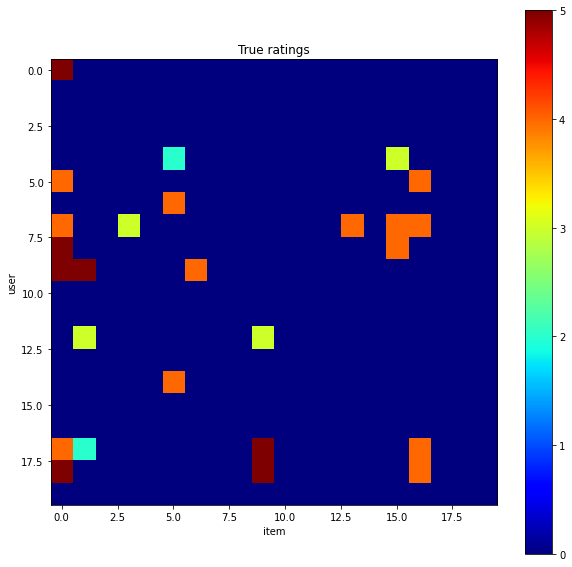

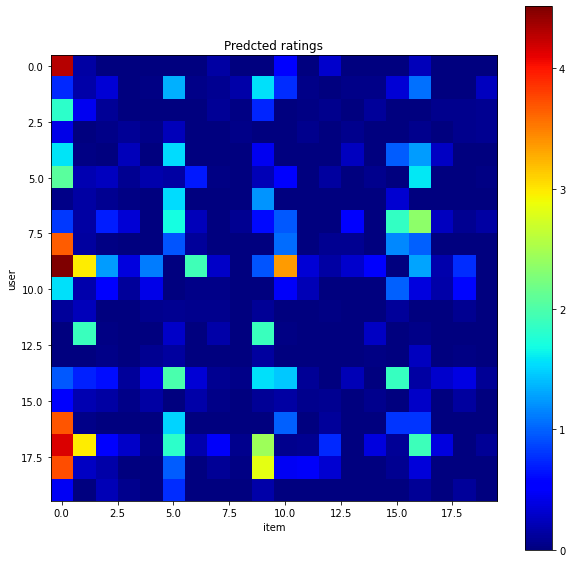

In [44]:
import matplotlib.pyplot as plt

nusers = 20
nitems = 20

plt.figure(figsize=(10,10))
plt.imshow(R[:nusers, :nitems], cmap='jet')
plt.xlabel('item')
plt.ylabel('user')
plt.title('True ratings')
plt.colorbar()


plt.figure(figsize=(10,10))
plt.imshow(Rpred[:nusers, :nitems], cmap='jet')
plt.xlabel('item')
plt.ylabel('user')
plt.title('Predcted ratings')
plt.colorbar()